Sun Han Week 1-4 Milestone 2

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Precision is ill-defined*")
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb  
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# Make sure the filename/path is correct for your situation.
df = pd.read_csv("C:/Users/sunwo/Desktop/School/Summer 2025/Applied Data Science/Week 1-4/credit_card_fraud_dataset.csv", parse_dates=["TransactionDate"])

# Display the first few rows
print(df.head())

   TransactionID            TransactionDate   Amount  MerchantID  \
0              1 2024-04-03 14:15:35.462794  4189.27         688   
1              2 2024-03-19 13:20:35.462824  2659.71         109   
2              3 2024-01-08 10:08:35.462834   784.00         394   
3              4 2024-04-13 23:50:35.462850  3514.40         944   
4              5 2024-07-12 18:51:35.462858   369.07         475   

  TransactionType      Location  IsFraud  
0          refund   San Antonio        0  
1          refund        Dallas        0  
2        purchase      New York        0  
3        purchase  Philadelphia        0  
4        purchase       Phoenix        0  


In [43]:
# Extract temporal features from TransactionDate 

# 2a) Convert the 'TransactionDate' column to datetime format  
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"], errors="coerce")

# 2b) Create new temporal features from the datetime column
df["Trans_Year"]      = df["TransactionDate"].dt.year        # Year of transaction
df["Trans_Month"]     = df["TransactionDate"].dt.month       # Month of transaction
df["Trans_Day"]       = df["TransactionDate"].dt.day         # Day of the month
df["Trans_DayOfWeek"] = df["TransactionDate"].dt.dayofweek   # Day of week (Monday=0)
df["Trans_Hour"]      = df["TransactionDate"].dt.hour        # Hour of the day

# 2c) Create a binary flag to indicate whether the transaction occurred on a weekend
df["Trans_IsWeekend"] = df["TransactionDate"].dt.dayofweek.isin([5, 6]).astype(int)  # 1 = Weekend, 0 = Weekday

# 2d) Preserve the original timestamp in case it's needed later for plotting or sorting
df["Trans_Timestamp"] = df["TransactionDate"]

# Print
print(df.head())

   TransactionID            TransactionDate   Amount  MerchantID  \
0              1 2024-04-03 14:15:35.462794  4189.27         688   
1              2 2024-03-19 13:20:35.462824  2659.71         109   
2              3 2024-01-08 10:08:35.462834   784.00         394   
3              4 2024-04-13 23:50:35.462850  3514.40         944   
4              5 2024-07-12 18:51:35.462858   369.07         475   

  TransactionType      Location  IsFraud  Trans_Year  Trans_Month  Trans_Day  \
0          refund   San Antonio        0        2024            4          3   
1          refund        Dallas        0        2024            3         19   
2        purchase      New York        0        2024            1          8   
3        purchase  Philadelphia        0        2024            4         13   
4        purchase       Phoenix        0        2024            7         12   

   Trans_DayOfWeek  Trans_Hour  Trans_IsWeekend            Trans_Timestamp  
0                2          14   

In [44]:
# Checking for null values
df.isnull().sum()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
Trans_Year         0
Trans_Month        0
Trans_Day          0
Trans_DayOfWeek    0
Trans_Hour         0
Trans_IsWeekend    0
Trans_Timestamp    0
dtype: int64

In [45]:
# Check for duplicate records 

# Check for fully duplicated rows in the dataset
print(f"Total duplicate rows: {df.duplicated().sum()}")

# Check specifically if 'TransactionID' has duplicates
print(f"Duplicate TransactionID entries: {df['TransactionID'].duplicated().sum()}")

Total duplicate rows: 0
Duplicate TransactionID entries: 0


In [46]:
# Examine transaction amount for range and outliers 
print(df['Amount'].describe())

count    100000.000000
mean       2497.092666
std        1442.415999
min           1.050000
25%        1247.955000
50%        2496.500000
75%        3743.592500
max        4999.770000
Name: Amount, dtype: float64


In [47]:
# Check unique values for categorical features

# Categories in 'TransactionType'
print("TransactionType values:", df['TransactionType'].unique())

# Categories in 'Location'
print("Location values:", df['Location'].unique())

TransactionType values: ['refund' 'purchase']
Location values: ['San Antonio' 'Dallas' 'New York' 'Philadelphia' 'Phoenix' 'Chicago'
 'San Jose' 'San Diego' 'Houston' 'Los Angeles']


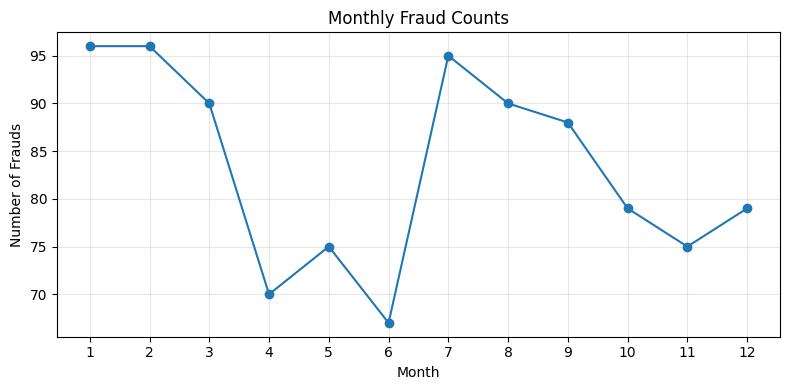

In [48]:
 # Line Plot: Monthly Fraud Counts
# Group by Trans_Month (1–12) and count how many frauds happened
monthly_counts = df[df['IsFraud'] == 1].groupby('Trans_Month').size().reindex(range(1, 13), fill_value=0)

plt.figure(figsize=(8, 4))
plt.plot(
    monthly_counts.index,
    monthly_counts.values,
    marker='o',
    linestyle='-'
)
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Number of Frauds')
plt.title('Monthly Fraud Counts')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

From the graph, January, February, and July have the highest fraud counts. 

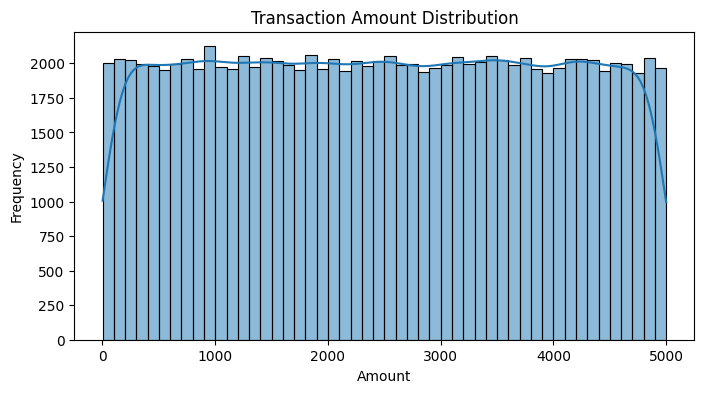

In [49]:
# Histogram of transaction amounts
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Amount', bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

The relatively uniform distribution across most of the range implies that most transactions fall into a broad, predictable range, which could be a sign of consistent consumer behavior.

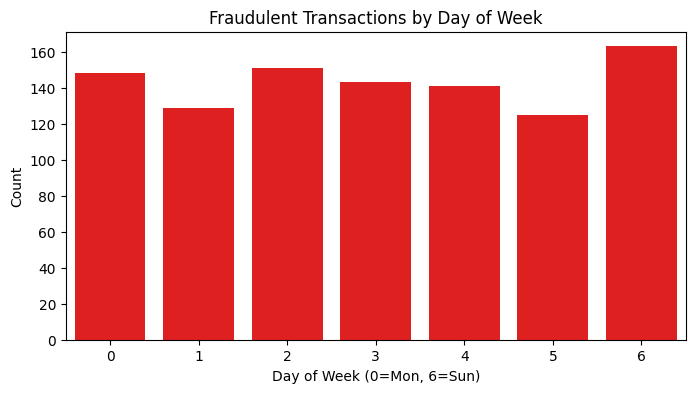

In [50]:
# Bar Chart of fraud by day of week
# Filter to only fraudulent transactions
fraud_df = df[df['IsFraud'] == 1]

# Plot count of fraudulent transactions by day of week
plt.figure(figsize=(8, 4))
sns.countplot(data=fraud_df, x='Trans_DayOfWeek', color='red')
plt.title("Fraudulent Transactions by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Count")
plt.show()

Sundays have a higher fraud count compared to other days. 

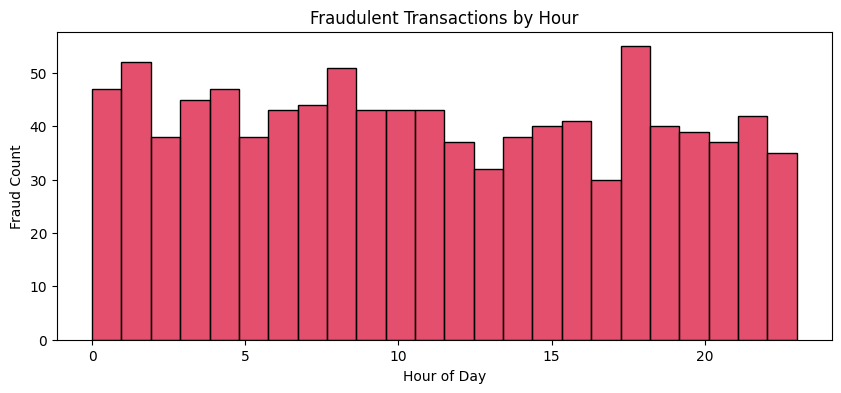

In [51]:
# Filter only fraudulent transactions
fraud_df = df[df['IsFraud'] == 1]

# Plot fraudulent transaction counts by hour of the day
plt.figure(figsize=(10, 4))
sns.histplot(data=fraud_df, x='Trans_Hour', bins=24, color='crimson')
plt.title("Fraudulent Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Count")
plt.show()

There are noticeable increases of fraudulent accidents around 1 AM and 4 PM. 

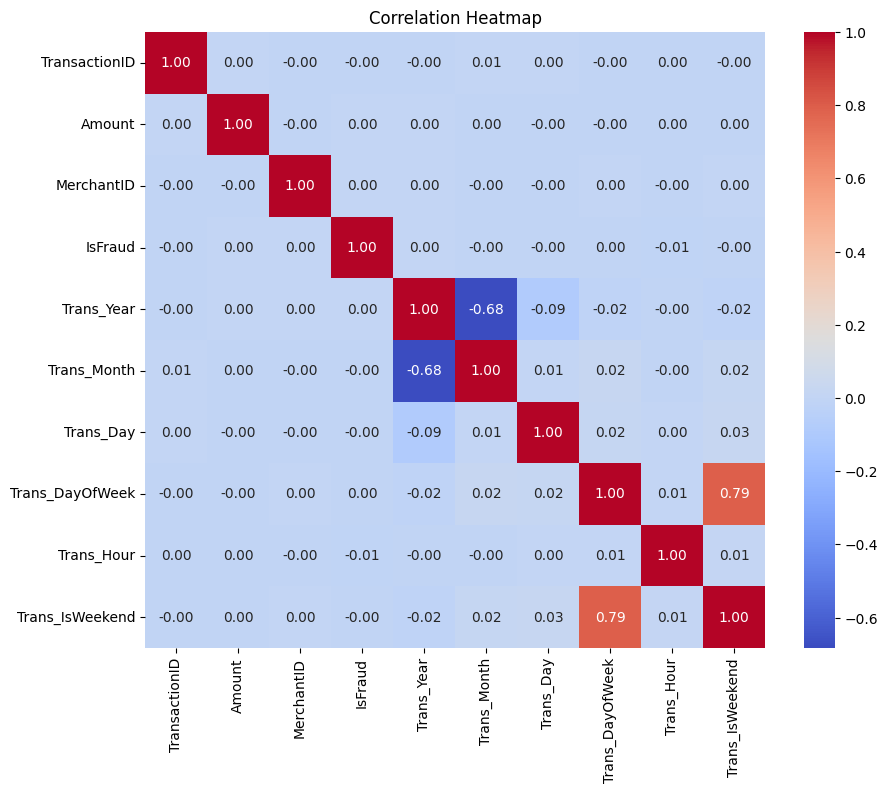

In [52]:
# Heatmap of numeric feature correlations
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

From the correlation heatmap, fraud isn’t obviously driven by basic transaction features like time, merchant, or amount alone. That’s a sign that more complex patterns are behind fraud activity.

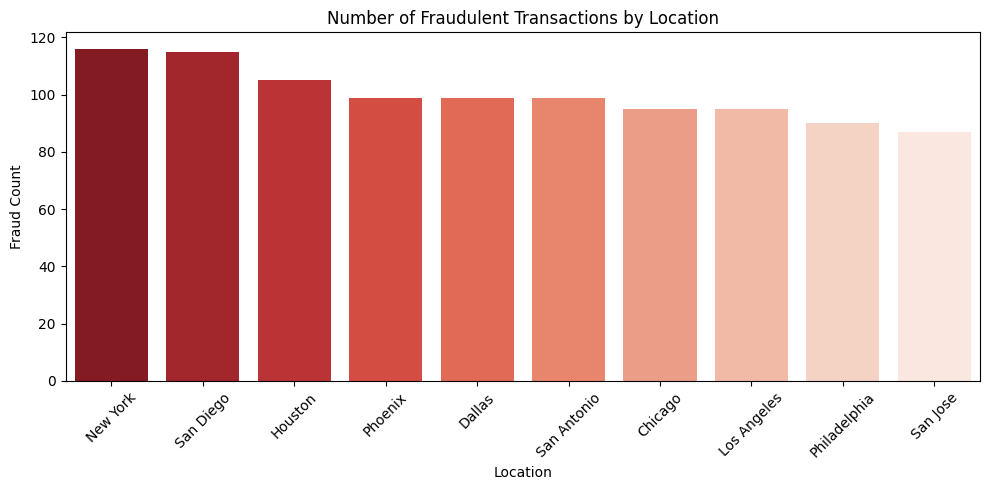

In [53]:
#Fraud by location
# Filter only fraudulent transactions
fraud_by_location = df[df['IsFraud'] == 1]['Location'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_by_location.index, y=fraud_by_location.values, palette="Reds_r")
plt.title("Number of Fraudulent Transactions by Location")
plt.xlabel("Location")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
# One-hot encode categorical columns 
df_encoded = pd.get_dummies(
    df,
    columns=["TransactionType", "Location"],
    drop_first=True  # Avoid dummy variable trap
)

# Preview the encoded DataFrame
print(df_encoded.head())

   TransactionID            TransactionDate   Amount  MerchantID  IsFraud  \
0              1 2024-04-03 14:15:35.462794  4189.27         688        0   
1              2 2024-03-19 13:20:35.462824  2659.71         109        0   
2              3 2024-01-08 10:08:35.462834   784.00         394        0   
3              4 2024-04-13 23:50:35.462850  3514.40         944        0   
4              5 2024-07-12 18:51:35.462858   369.07         475        0   

   Trans_Year  Trans_Month  Trans_Day  Trans_DayOfWeek  Trans_Hour  ...  \
0        2024            4          3                2          14  ...   
1        2024            3         19                1          13  ...   
2        2024            1          8                0          10  ...   
3        2024            4         13                5          23  ...   
4        2024            7         12                4          18  ...   

   TransactionType_refund Location_Dallas  Location_Houston  \
0                    Tr

In [55]:
# Drop merchant and transaction ID
df_encoded.drop(columns=['TransactionID'], inplace=True)   
print(df_encoded.head())

             TransactionDate   Amount  MerchantID  IsFraud  Trans_Year  \
0 2024-04-03 14:15:35.462794  4189.27         688        0        2024   
1 2024-03-19 13:20:35.462824  2659.71         109        0        2024   
2 2024-01-08 10:08:35.462834   784.00         394        0        2024   
3 2024-04-13 23:50:35.462850  3514.40         944        0        2024   
4 2024-07-12 18:51:35.462858   369.07         475        0        2024   

   Trans_Month  Trans_Day  Trans_DayOfWeek  Trans_Hour  Trans_IsWeekend  ...  \
0            4          3                2          14                0  ...   
1            3         19                1          13                0  ...   
2            1          8                0          10                0  ...   
3            4         13                5          23                1  ...   
4            7         12                4          18                0  ...   

  TransactionType_refund  Location_Dallas  Location_Houston  \
0          

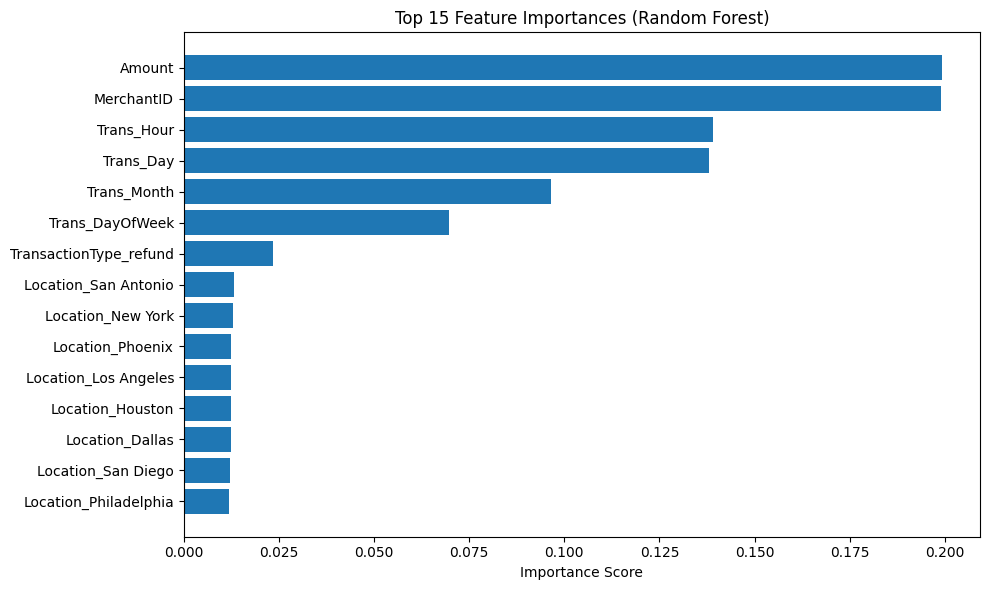

In [62]:
# Random Forest
# Drop 'IsFraud' and 'TransactionID' from feature set
X = df_encoded.drop(columns=["IsFraud", "TransactionDate", "Trans_Timestamp"])
y = df_encoded["IsFraud"]

# Split into training and testing sets 
# Stratify ensures both sets keep same fraud/non-fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Initialize and train Random Forest model 
# Using class_weight='balanced' to handle class imbalance
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Extract and sort feature importances 
importances = rf.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 15 features by importance
top15 = feat_imp_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(
    y=top15["feature"][::-1],              
    width=top15["importance"][::-1]
)
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

Confusion Matrix:
[[19800     0]
 [  200     0]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19800
           1       0.00      0.00      0.00       200

    accuracy                           0.99     20000
   macro avg       0.49      0.50      0.50     20000
weighted avg       0.98      0.99      0.99     20000

Precision (fraud): 0.0
Recall (fraud): 0.0
F1 Score (fraud): 0.0


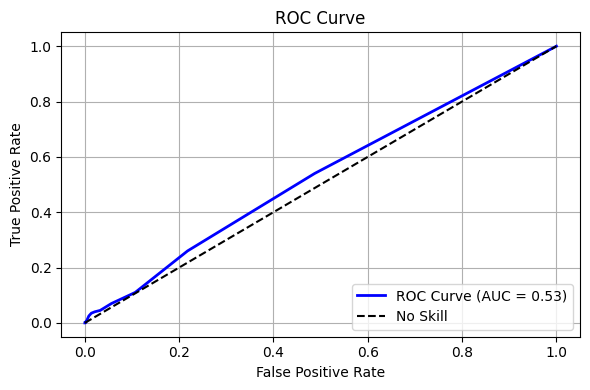

ROC AUC Score: 0.53


In [57]:
# Make predictions 
y_pred = rf.predict(X_test)                      # Predicted classes
y_proba = rf.predict_proba(X_test)[:, 1]         # Predicted probabilities for positive class

# Evaluation metrics 
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Precision (fraud):", round(precision_score(y_test, y_pred, pos_label=1), 4))
print("Recall (fraud):", round(recall_score(y_test, y_pred, pos_label=1), 4))
print("F1 Score (fraud):", round(f1_score(y_test, y_pred, pos_label=1), 4))

# ROC Curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("ROC AUC Score:", round(roc_auc, 4))

Confusion Matrix:
 [[16873  2927]
 [  161    39]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9905    0.8522    0.9162     19800
           1     0.0131    0.1950    0.0246       200

    accuracy                         0.8456     20000
   macro avg     0.5018    0.5236    0.4704     20000
weighted avg     0.9808    0.8456    0.9072     20000

Precision (fraud): 0.0131
Recall (fraud): 0.195
F1 Score (fraud): 0.0246


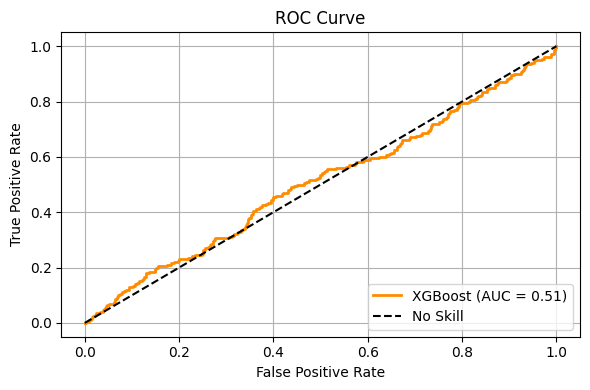

ROC AUC Score: 0.5067


In [65]:
# Handle Class Imbalance

# Calculate scale_pos_weight to handle class imbalance:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBClassifier with parameters
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42, 
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight  # Balance positive class
)

# Train the model
model.fit(X_train, y_train)

# Predict class labels and probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Precision (fraud):", round(precision_score(y_test, y_pred, pos_label=1), 4))
print("Recall (fraud):", round(recall_score(y_test, y_pred, pos_label=1), 4))
print("F1 Score (fraud):", round(f1_score(y_test, y_pred, pos_label=1), 4))

# Plot ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print("ROC AUC Score:", round(roc_auc, 4))

Class distribution BEFORE SMOTE:
IsFraud
0    79200
1      800
Name: count, dtype: int64

Class distribution AFTER SMOTE:
IsFraud
0    79200
1    79200
Name: count, dtype: int64
Confusion Matrix:
[[19485   315]
 [  199     1]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9899    0.9841    0.9870     19800
           1     0.0032    0.0050    0.0039       200

    accuracy                         0.9743     20000
   macro avg     0.4965    0.4945    0.4954     20000
weighted avg     0.9800    0.9743    0.9772     20000


ROC AUC Score: 0.5133


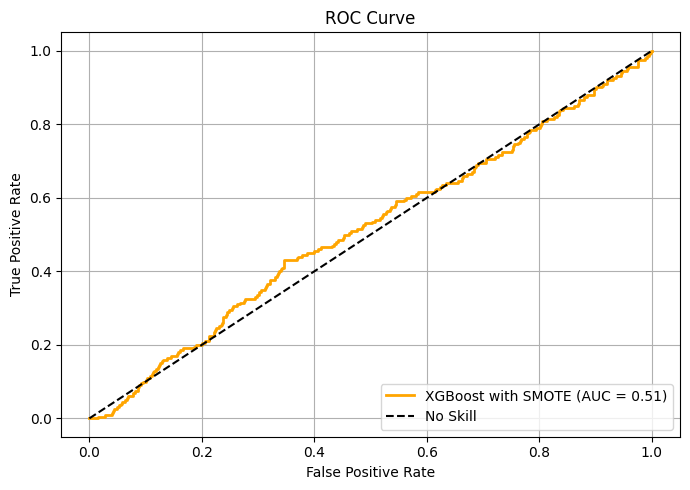

In [66]:
# XGBoost
# Apply SMOTE to training data  
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Class distribution BEFORE SMOTE:")
print(y_train.value_counts())
print("\nClass distribution AFTER SMOTE:")
print(pd.Series(y_resampled).value_counts())

#  Train XGBoost on resampled (balanced) data 
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_resampled, y_resampled)

#  Predict on test set and evaluate
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f"XGBoost with SMOTE (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='No Skill')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()